In [9]:
import os, sys

In [10]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import scipy.fftpack as sf
import scipy.linalg as sl
import numpy as np

In [11]:
!{sys.executable} -m numpy.f2py --quiet -c SPECIAL_BLEND.f90 -m SPECIAL_BLEND

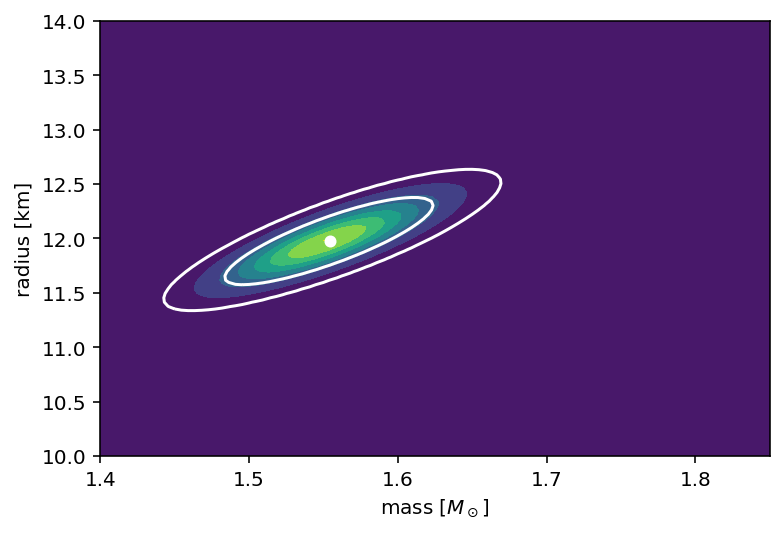

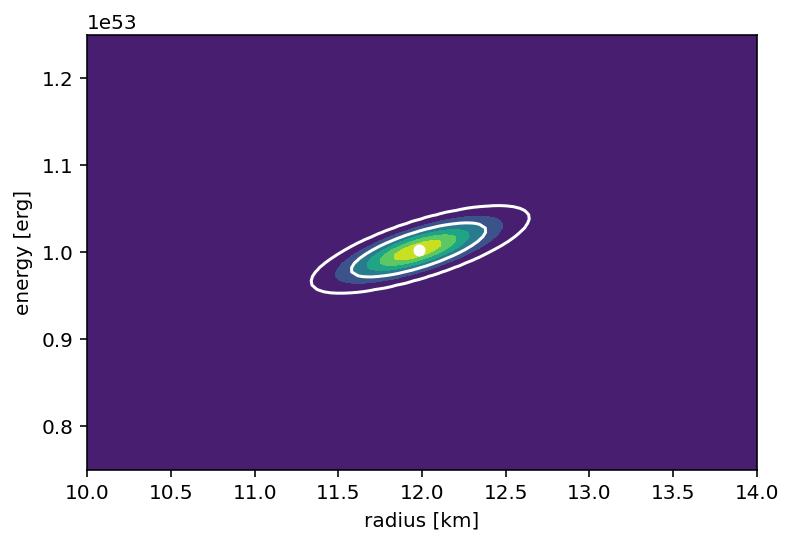

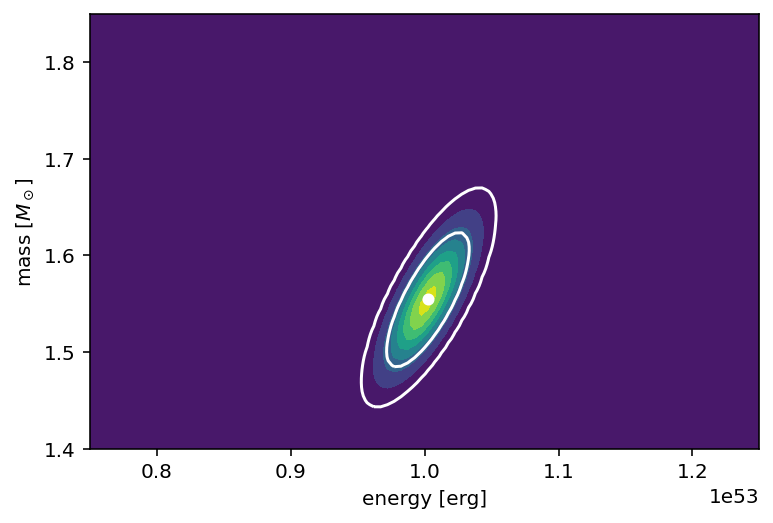

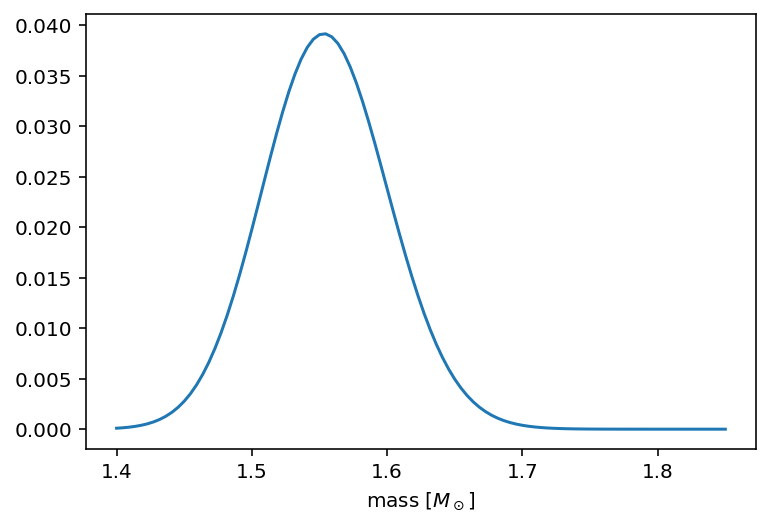

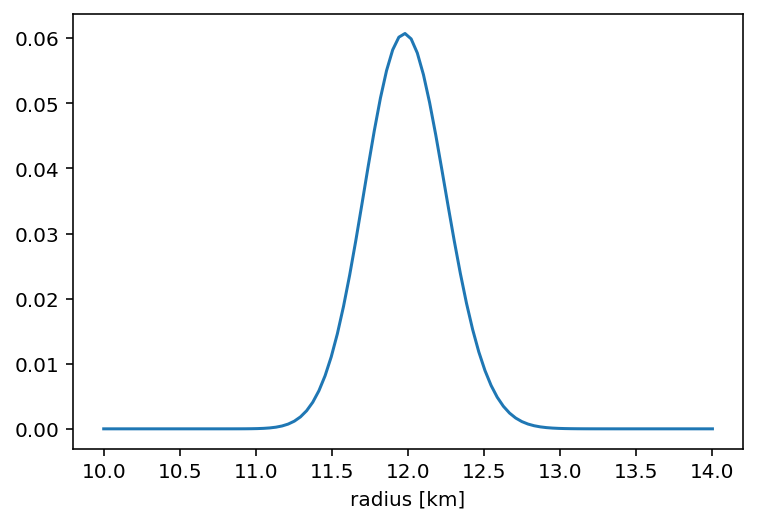

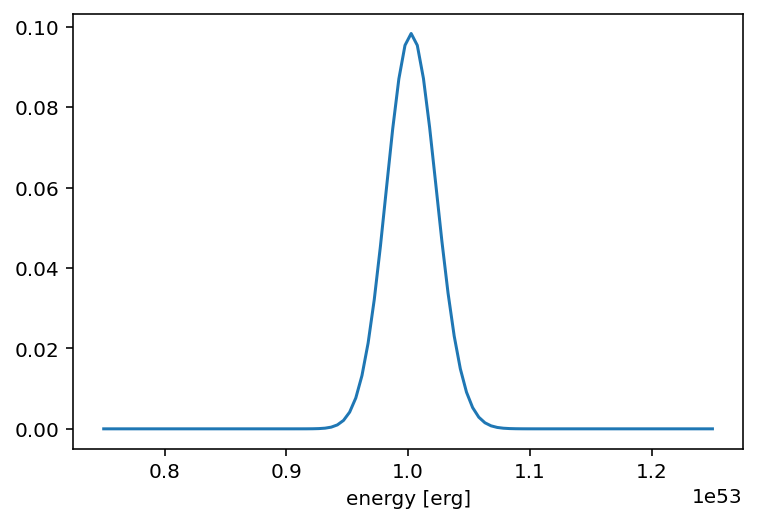

In [12]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import SPECIAL_BLEND as SB

def main():
  params = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/parameters.dat') # 'parameters.dat' file has the following contents: assumed gbeta, distance to the SN [kpc], detector mass [kton], parameter search grid number, minimum search mass [Msun], maximum search mass [Msun], minimum search radius [km], maximum search radius [km], minimum search energy [erg], and maximum search energy [erg]
  data = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/time_energy.dat') # 'time_energy.dat' file has the time and energy of each event: first column is time, second column is energy
  tbinnumber = int(params[10]) # 0: unbinned analysis, 1<=: number of bins for binned analysis

  if tbinnumber == 0:
    mlogLH,mass,rad,et = unbinned_likelihood(data,params)
  else:
    mlogLH,mass,rad,et = binned_likelihood(data,params)

  LH_MR,MRvals, LH_RE,REvals, LH_EM,EMvals, LH_M, LH_R, LH_E = marginalizeLH(mass,rad,et,mlogLH)
  save_likelihood(mass,rad,et,mlogLH,LH_MR,LH_RE,LH_EM,LH_M,LH_R,LH_E)
  visualize(mass,rad,et,mlogLH,LH_MR,MRvals,LH_RE,REvals,LH_EM,EMvals,LH_M,LH_R,LH_E)


def unbinned_likelihood(data,params):
  datsize = data.shape[0]
  tdata = data[:,0]
  edata = data[:,1]
  gbeta = params[0]
  dist = params[1]
  Mdet = params[2]
  nparam = int(params[3])
  mmin = params[4]
  mmax = params[5]
  rmin = params[6]
  rmax = params[7]
  emin = params[8]
  emax = params[9]

  mass = np.linspace(mmin,mmax,nparam)
  rad  = np.linspace(rmin,rmax,nparam)
  et   = np.linspace(emin,emax,nparam)

  mlogLH = SB.eval_unbinned_likelihood(tdata,edata,mass,rad,et,gbeta,dist,Mdet)
    
  return mlogLH,mass,rad,et

def binned_likelihood(data,params):
  datsize = data.shape[0]
  tdata = data[:,0]
  edata = data[:,1]
  gbeta = params[0]
  dist = params[1]
  Mdet = params[2]
  nparam = int(params[3])
  mmin = params[4]
  mmax = params[5]
  rmin = params[6]
  rmax = params[7]
  emin = params[8]
  emax = params[9]
  tbinnumber = int(params[10])
  dt_min = params[11]
  tmax   = params[12]
  
  t_bin,dt,e_bin,de,hist,status = SB.binning(tdata,edata,dt_min,tmax,tbinnumber)
  if status >= 1:
    print("binning error, try another bin number")
    interrupt_by_undefined_function()
  
  mass = np.linspace(mmin,mmax,nparam)
  rad  = np.linspace(rmin,rmax,nparam)
  et   = np.linspace(emin,emax,nparam)

  mlogLH = SB.eval_binned_likelihood(t_bin,dt,e_bin,de,hist,mass,rad,et,gbeta,dist,Mdet)
  return mlogLH,mass,rad,et


def marginalizeLH(mass,rad,et,mlogLH):
  LH_MR,CI95level,CI68level,peak = SB.mr_marginalize(mass,rad,et,mlogLH)
  MRvals  = [CI95level,CI68level,peak[0],peak[1]]
  LH_RE,CI95level,CI68level,peak = SB.re_marginalize(mass,rad,et,mlogLH)
  REvals  = [CI95level,CI68level,peak[0],peak[1]]
  LH_EM,CI95level,CI68level,peak = SB.em_marginalize(mass,rad,et,mlogLH)
  EMvals  = [CI95level,CI68level,peak[0],peak[1]]
  LH_M  = SB.m_marginalize(mass,rad,et,mlogLH)
  LH_R  = SB.r_marginalize(mass,rad,et,mlogLH)
  LH_E  = e_marginalize(mass,rad,et,mlogLH)

  return LH_MR,MRvals,LH_RE,REvals,LH_EM,EMvals,LH_M,LH_R,LH_E


def save_likelihood(mass,rad,et,mlogLH,LH_MR,LH_RE,LH_EM,LH_M,LH_R,LH_E):
  Marray = np.stack([mass,LH_M],1)
  Mhead = [['mass',  'LH_M']]
  with open("LH_M.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([Mhead,Marray],0))
  
  Rarray = np.stack([rad, LH_R],1)
  Rhead = [['radius','LH_R']]
  with open("LH_R.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([Mhead,Marray],0))
  
  Earray = np.stack([et,  LH_E],1)
  Ehead = [['energy','LH_E']]
  with open("LH_E.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([Mhead,Marray],0))

  mrm,mrr = np.meshgrid(mass,rad)
  rer,ree = np.meshgrid(rad,et)
  eme,emm = np.meshgrid(et,mass)

  mrm1    = np.ravel(mrm)
  mrr1    = np.ravel(mrr)
  LH_MR1  = np.ravel(LH_MR)
  MRarray = np.stack([mrm1,mrr1,LH_MR1]).T
  MRhead  = [['mass','radius','LH_MR']]
  with open("LH_MR.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([MRhead,MRarray],0))

  rer1    = np.ravel(rer)
  ree1    = np.ravel(ree)
  LH_RE1  = np.ravel(LH_RE)
  REarray = np.stack([rer1,ree1,LH_RE1]).T
  REhead  = [['radius','energy','LH_RE']]
  with open("LH_RE.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([REhead,REarray],0))

  eme1    = np.ravel(eme)
  emm1    = np.ravel(emm)
  LH_EM1  = np.ravel(LH_EM)
  EMarray = np.stack([eme1,emm1,LH_EM1]).T
  EMhead  = [['energy','mass','LH_EM']]
  with open("LH_EM.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(np.concatenate([EMhead,EMarray],0))


def visualize(mass,rad,et,mlogLH,LH_MR,MRvals,LH_RE,REvals,LH_EM,EMvals,LH_M,LH_R,LH_E):
  mrm,mrr = np.meshgrid(mass,rad)
  plt.contourf(mrm,mrr,LH_MR.T)
  plt.contour(mrm,mrr,LH_MR.T,colors=['white'],levels=[MRvals[0],MRvals[1]])
  plt.plot(MRvals[2],MRvals[3],color='white',marker='.',markersize=10)
  plt.xlabel(r"mass [$M_\odot$]")
  plt.ylabel(r"radius [km]")
  plt.show()

  rer,ree = np.meshgrid(rad,et)
  plt.contourf(rer,ree,LH_RE.T)
  plt.contour(rer,ree,LH_RE.T,colors=['white'],levels=[REvals[0],REvals[1]])
  plt.plot(REvals[2],REvals[3],color='white',marker='.',markersize=10)
  plt.xlabel(r"radius [km]")
  plt.ylabel(r"energy [erg]")
  plt.show()

  eme,emm = np.meshgrid(et,mass)
  plt.contourf(eme,emm,LH_EM.T)
  plt.contour(eme,emm,LH_EM.T,colors=['white'],levels=[EMvals[0],EMvals[1]])
  plt.plot(EMvals[2],EMvals[3],color='white',marker='.',markersize=10)
  plt.xlabel(r"energy [erg]")
  plt.ylabel(r"mass [$M_\odot$]")
  plt.show()

  plt.plot(mass,LH_M)
  plt.xlabel(r"mass [$M_\odot$]")
  plt.show()

  plt.plot(rad,LH_R)
  plt.xlabel(r"radius [km]")
  plt.show()

  plt.plot(et,LH_E)
  plt.xlabel(r"energy [erg]")
  plt.show()

if __name__ == "__main__":
    main()

